In [172]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the u.data dataset
columns = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_csv("u.data", sep="\t", names=columns)

# Drop the timestamp column as it is not needed
data = data.drop(columns=["timestamp"])

# Encode user_id and item_id for PyTorch compatibility
data['user_id'] = data['user_id'] - 1
data['item_id'] = data['item_id'] - 1




In [173]:
data.head()

,user_id,item_id,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1


In [174]:
# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
train_users = torch.tensor(train_data['user_id'].values, dtype=torch.long)
train_items = torch.tensor(train_data['item_id'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_users = torch.tensor(test_data['user_id'].values, dtype=torch.long)
test_items = torch.tensor(test_data['item_id'].values, dtype=torch.long)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

In [175]:
import torch.nn as nn

class CollaborativeFilteringModel(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(CollaborativeFilteringModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        dot_product = torch.mul(user_emb, item_emb).sum(dim=1)
        return dot_product

# Initialize the model
num_users = data['user_id'].nunique()
num_items = data['item_id'].nunique()
latent_dim = 20

model = CollaborativeFilteringModel(num_users, num_items, latent_dim)


In [188]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 50

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(train_users, train_items)
    loss = criterion(predictions, train_ratings)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_users, test_items)
        test_loss = criterion(test_preds, test_ratings)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 10/50, Train Loss: 0.3270, Test Loss: 30.6551
Epoch 20/50, Train Loss: 0.1425, Test Loss: 28.7083
Epoch 30/50, Train Loss: 0.0717, Test Loss: 27.6647
Epoch 40/50, Train Loss: 0.0410, Test Loss: 27.1879
Epoch 50/50, Train Loss: 0.0261, Test Loss: 27.0216


In [182]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define learning rate scheduler (reduce learning rate by a factor of 0.5 every 10 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Set number of epochs and patience for early stopping
epochs = 50
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
patience_counter = 0

# Store training and test losses
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Training phase
    predictions = model(train_users, train_items)
    loss = criterion(predictions, train_ratings)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        test_preds = model(test_users, test_items)
        test_loss = criterion(test_preds, test_ratings)
        test_losses.append(test_loss.item())

    # Adjust learning rate using scheduler
    scheduler.step()

    # Early stopping check
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping after epoch {epoch + 1}")
        break

    # Print training and validation loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")




Epoch 10/50, Train Loss: 8.2116, Test Loss: 54.1221
Epoch 20/50, Train Loss: 5.7113, Test Loss: 50.4208
Epoch 30/50, Train Loss: 4.7857, Test Loss: 48.7984
Epoch 40/50, Train Loss: 4.3912, Test Loss: 48.0512
Epoch 50/50, Train Loss: 4.2088, Test Loss: 47.6931


In [187]:
import numpy as np
from sklearn.metrics import mean_absolute_error, f1_score, precision_score
from math import sqrt

# Function to discretize ratings into categories (e.g., Low and High)
def discretize_ratings(ratings, bins=[0, 3, 5]):
    """
    Discretizes the ratings into two categories: Low (0-3) and High (3-5).
    """
    ratings = np.clip(ratings, 0, 5)  # Ensure ratings are between 0 and 5
    return np.digitize(ratings, bins) - 1  # -1 because np.digitize returns index starting from 1

# Evaluate RMSE, MAE, F1 Score, and Precision
model.eval()
with torch.no_grad():
    # Get model predictions for train and test data
    train_preds = model(train_users, train_items)
    test_preds = model(test_users, test_items)
    
    # Calculate RMSE for train and test sets
    train_rmse = sqrt(mean_squared_error(train_ratings.numpy(), train_preds.numpy()))
    test_rmse = sqrt(mean_squared_error(test_ratings.numpy(), test_preds.numpy()))

    # Calculate MAE for train and test sets
    train_mae = mean_absolute_error(train_ratings.numpy(), train_preds.numpy())
    test_mae = mean_absolute_error(test_ratings.numpy(), test_preds.numpy())

    # Discretize ratings for F1 and Precision calculation
    true_train = discretize_ratings(train_ratings.numpy())
    pred_train = discretize_ratings(train_preds.numpy())
    true_test = discretize_ratings(test_ratings.numpy())
    pred_test = discretize_ratings(test_preds.numpy())

    # Calculate F1 Score and Precision
    train_f1 = f1_score(true_train, pred_train, average='weighted')
    test_f1 = f1_score(true_test, pred_test, average='weighted')
    
    train_precision = precision_score(true_train, pred_train, average='weighted', zero_division=1)
    test_precision = precision_score(true_test, pred_test, average='weighted', zero_division=1)

    # Print the evaluation metrics
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
    print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")


Train RMSE: 0.8742, Test RMSE: 5.8261
Train MAE: 0.5923, Test MAE: 4.4809
Train F1: 0.6495, Test F1: 0.2562
Train Precision: 0.6926, Test Precision: 0.4614


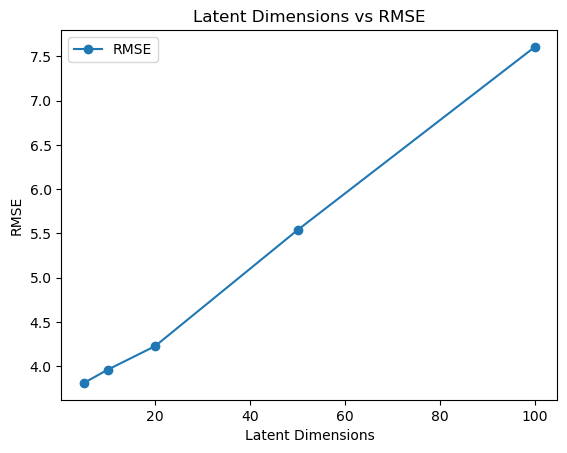

In [184]:
latent_dims = [5, 10, 20, 50, 100]
rmse_values = []

for latent_dim in latent_dims:
    model = CollaborativeFilteringModel(num_users, num_items, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(train_users, train_items)
        loss = criterion(predictions, train_ratings)
        loss.backward()
        optimizer.step()

    # Evaluate RMSE for each latent dimension
    model.eval()
    with torch.no_grad():
        test_preds = model(test_users, test_items)
    rmse = np.sqrt(mean_squared_error(test_ratings.numpy(), test_preds.numpy()))
    rmse_values.append(rmse)

# Plot Latent Dimensions vs RMSE
import matplotlib.pyplot as plt

plt.plot(latent_dims, rmse_values, marker='o', label='RMSE')
plt.xlabel('Latent Dimensions')
plt.ylabel('RMSE')
plt.title('Latent Dimensions vs RMSE')
plt.legend()
plt.show()


In [6]:
torch.save(model.state_dict(), 'matrix_factorization_model.pth')


In [7]:
def recommend(user_id, top_n=5):
    user_vector = torch.tensor([user_id - 1])
    item_vector = torch.arange(n_items)
    scores = model(user_vector, item_vector).detach().numpy()
    recommendations = np.argsort(scores)[-top_n:][::-1]
    return recommendations + 1  # Adjust to match original item IDs

print("Recommended items for user 1:", recommend(1))


Recommended items for user 1: [  74 1484  631 1528  725]


Epoch 10/50, RMSE: 3.4345
Epoch 20/50, RMSE: 2.9926
Epoch 30/50, RMSE: 2.5341
Epoch 40/50, RMSE: 2.1473
Epoch 50/50, RMSE: 1.8615


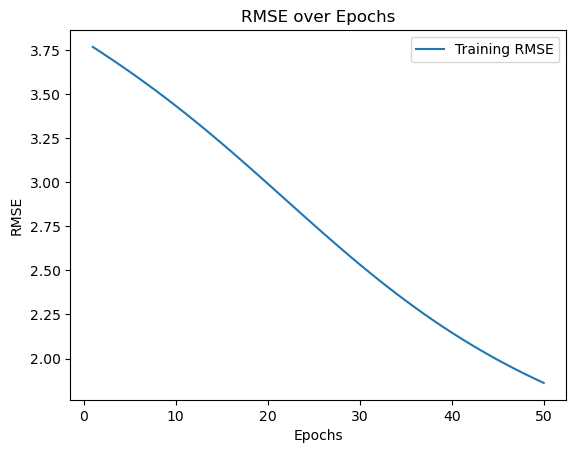

In [35]:
# Training loop with RMSE computation
train_rmses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(train_users, train_items)
    loss = criterion(predictions, train_ratings)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate RMSE
    with torch.no_grad():
        rmse = torch.sqrt(torch.mean((predictions - train_ratings) ** 2)).item()
        train_rmses.append(rmse)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, RMSE: {rmse:.4f}")

# Plot RMSE over epochs
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), train_rmses, label='Training RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.show()


## Scraping code

In [49]:
item_column_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'] # Column-Names are defined manually based on given data.
items = pd.read_csv(r"C:\Users\91951\OneDrive\Desktop\pythonProject\sem 3\social media\project\u.item", sep = '|', names = item_column_names, encoding = 'latin-1')

In [50]:
def extract_title(movie):
    match = re.match(r'^(.*?)\s*\(.*\)', movie)
    if match:
        return match.group(1).strip()
    return movie
items['search']=items['movie_title'].apply(extract_title)

In [51]:
print(items['movie_title'][1677])

Mat' i syn (1997)


In [53]:
items.iloc[5]

movie_id                                                              6
movie_title           Shanghai Triad (Yao a yao yao dao waipo qiao) ...
release_date                                                01-Jan-1995
video_release_date                                                  NaN
IMDb_URL              http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...
unknown                                                               0
Action                                                                0
Adventure                                                             0
Animation                                                             0
Children                                                              0
Comedy                                                                0
Crime                                                                 0
Documentary                                                           0
Drama                                                           

In [76]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re
import random  # Import random for delays

# Path to your Edge WebDriver executable
driver_path = r"C:\Users\91951\Downloads\edgedriver_win64\msedgedriver.exe"
service = Service(driver_path)

# Initialize WebDriver
driver = webdriver.Edge(service=service)

# List to store scraped data
scraped_data = []

# Maximum number of reviews to scrape per movie
MAX_REVIEWS = 10

# Open the Rotten Tomatoes homepage only once at the start
driver.get("https://www.rottentomatoes.com/")
time.sleep(2)  # Wait for the page to load

# Iterate through each movie in the items DataFrame
for index, row in items.iterrows():  # Adjust the range for more movies
    hashtag = row['search']  # Get the movie title from the column
    movie_id1=row['movie_id']
 
    search_term = hashtag.replace("_", " ")  # Convert to search term for search bar

    # Search for the movie directly
    try:
        # Locate the search bar using its aria-label attribute
        search_bar = driver.find_element(By.CSS_SELECTOR, "input[aria-label='Search']")
        search_bar.clear()  # Clear the search bar before typing new search term
        search_bar.send_keys(search_term)
        time.sleep(1)

        # Click the search button
        search_button = driver.find_element(By.CSS_SELECTOR, ".search-submit")
        search_button.click()
        time.sleep(3)

        # Navigate to the first search result
        search_results_list = driver.find_element(By.CSS_SELECTOR, "ul[slot='list']")
        first_link = search_results_list.find_element(By.CSS_SELECTOR, "a.unset")
        first_link.click()
        time.sleep(3)

        # Extract the movie ID from the current URL
        movie_id = driver.current_url.split("/")[4]  # Extracts the movie ID from URL

        # Construct the reviews URL
        reviews_url = f"https://www.rottentomatoes.com/m/{movie_id}/reviews"

        # Navigate directly to the reviews page
        driver.get(reviews_url)
        time.sleep(3)

        review_count = 0  # Counter to limit reviews per movie
        while review_count < MAX_REVIEWS:
            # Locate all the review text containers on the page
            containers = driver.find_elements(By.CLASS_NAME, "review-text-container")

            for container in containers:
                if review_count >= MAX_REVIEWS:
                    break  # Stop collecting once the limit is reached

                # Extract all <p> tags with the class "review-text" within the container
                p_elements = container.find_elements(By.CLASS_NAME, "review-text")
                for p_element in p_elements:
                    if review_count >= MAX_REVIEWS:
                        break
                    text = p_element.text.strip()  # Extract and clean the text
                    # print(text)
                    if text:  # Only store non-empty text
                        scraped_data.append({
                            "Hashtag": hashtag,
                            "Text": text,
                            'id':movie_id1
                        })
                        review_count += 1  # Increment the counter

            # If we have enough reviews, break the loop
            if review_count >= MAX_REVIEWS:
                break

            # Check if there is a "Load More" button inside the div with class 'load-more-container'
            try:
                # Scroll down the page to make the "Load More" button visible
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)  # Wait for the page to load after scrolling

                # Find and click the "Load More" button
                load_more_container = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "load-more-container"))
                )
                load_more_button = load_more_container.find_element(By.TAG_NAME, "rt-button")
                ActionChains(driver).move_to_element(load_more_button).click().perform()
                time.sleep(random.uniform(3, 5))  # Random delay for human-like behavior
            except Exception as e:
                print(f"No more reviews to load or an error occurred for movie '{cleaned_title}': {e}")
                break  # Exit the loop if there is no "Load More" button or no more reviews

    except Exception as e:
        print(f"Error scraping movie '{cleaned_title}': {e}")

# Optionally, save the scraped data to a CSV file
df = pd.DataFrame(scraped_data)

# Save the final DataFrame containing the reviews
df.to_csv("scraped_review.csv", index=False)

# Close the browser (uncomment to close immediately after scraping)
driver.quit()


Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

Error scraping movie 'Richard III': Message: no such element: Unable to locate element: {"method":"css selector","selector":"ul[slot='list']"}
  (Session info: MicrosoftEdge=131.0.2903.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB4C9DB]
	(No symbol) [0x00007FF6ADB4CAE3]
	(No symbol) [0x00007FF6ADB892F7]
	(No symbol) [0x00007FF6ADB6C1DF]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Ev

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

No more reviews to load or an error occurred for movie 'Richard III': Message: javascript error: {"status":60,"value":"[object HTMLElement] has no size and location"}
  (Session info: MicrosoftEdge=131.0.2903.86)
Stacktrace:
	(No symbol) [0x00007FF6ADC26B05]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADF4F474+1437348]
	sqlite3_dbdata_init [0x00007FF6ADFF2DA6+643174]
	(No symbol) [0x00007FF6ADB0AD3C]
	(No symbol) [0x00007FF6ADB0D32C]
	(No symbol) [0x00007FF6ADB0D3FF]
	(No symbol) [0x00007FF6ADB52400]
	(No symbol) [0x00007FF6ADB519BE]
	(No symbol) [0x00007FF6ADB91990]
	(No symbol) [0x00007FF6ADB6C19A]
	(No symbol) [0x00007FF6ADB43437]
	(No symbol) [0x00007FF6ADB86BFF]
	(No symbol) [0x00007FF6ADB6BE03]
	(No symbol) [0x00007FF6ADB42984]
	(No symbol) [0x00007FF6ADB41E30]
	(No symbol) [0x00007FF6ADB42571]
	Microsoft::Applications::Events::EventProperty::empty [0x00007FF6ADEFBB04+1094964]
	(No symbol) [0x00007FF6ADC632B8]
	Microsoft::Applications::Events::EventProperty:

## Setiment analysis

In [60]:
!pip install nltk vaderSentiment


  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   --- ------------------------------------ 10.2/126.0 kB ? eta -:--:--
   --------- ----------------------------- 30.7/126.0 kB 330.3 kB/s eta 0:00:01
   --------------------------------- ---- 112.6/126.0 kB 819.2 kB/s eta 0:00:01
   -------------------------------------- 126.0/126.0 kB 826.5 kB/s eta 0:00:00


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [77]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91951\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91951\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
movie_review=pd.read_csv('scraped_review.csv')

In [79]:
movie_review.head()

,Hashtag,Text,id
0,Toy Story,John Lasseter has delivered a great adventure ...,1
1,Toy Story,Children must eventually outgrow their toys an...,1
2,Toy Story,"Despite the animation not holding up, Toy Stor...",1
3,Toy Story,"You don't have to be a kid to enjoy it, just h...",1
4,Toy Story,"... a tight, inventive script that balances st...",1


In [80]:
def clean_text(text):
    # Remove special characters, digits, and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text and remove stop words
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_text)

In [81]:
# Apply text cleaning function
movie_review['Cleaned_Text'] = movie_review['Text'].apply(clean_text)


In [82]:
movie_review.head()

,Hashtag,Text,id,Cleaned_Text
0,Toy Story,John Lasseter has delivered a great adventure ...,1,john lasseter delivered great adventure story ...
1,Toy Story,Children must eventually outgrow their toys an...,1,children must eventually outgrow toys existent...
2,Toy Story,"Despite the animation not holding up, Toy Stor...",1,despite animation holding toy story flawless m...
3,Toy Story,"You don't have to be a kid to enjoy it, just h...",1,dont kid enjoy sense humor
4,Toy Story,"... a tight, inventive script that balances st...",1,tight inventive script balances strongly etche...


In [83]:
# Function to get sentiment score
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound score (overall sentiment)


In [84]:
# Apply sentiment analysis
movie_review['Sentiment_Score'] = movie_review['Cleaned_Text'].apply(get_sentiment)

movie_review.head()

,Hashtag,Text,id,Cleaned_Text,Sentiment_Score
0,Toy Story,John Lasseter has delivered a great adventure ...,1,john lasseter delivered great adventure story ...,0.9201
1,Toy Story,Children must eventually outgrow their toys an...,1,children must eventually outgrow toys existent...,-0.2263
2,Toy Story,"Despite the animation not holding up, Toy Stor...",1,despite animation holding toy story flawless m...,0.7964
3,Toy Story,"You don't have to be a kid to enjoy it, just h...",1,dont kid enjoy sense humor,-0.1351
4,Toy Story,"... a tight, inventive script that balances st...",1,tight inventive script balances strongly etche...,0.5829


In [85]:
# Group by 'id' and calculate the average sentiment score
average_sentiment = movie_review.groupby('id')['Sentiment_Score'].mean().reset_index()


In [86]:
average_sentiment.head(10)

,id,Sentiment_Score
0,1,0.42085
1,2,0.10783
2,3,-0.18493
3,4,0.46766
4,5,-0.02828
5,6,-0.11738
6,7,0.04579
7,8,0.65492
8,9,0.20219
9,10,0.01851


In [91]:
average_sentiment.to_csv("average_sentiment.csv", index=False)

In [87]:
average_sentiment.shape

(1068, 2)

In [74]:
movie_review

,Hashtag,Text,id,Cleaned_Text,Sentiment_Score
0,Toy Story,John Lasseter has delivered a great adventure ...,1,john lasseter delivered great adventure story ...,0.9201
1,Toy Story,Children must eventually outgrow their toys an...,1,children must eventually outgrow toys existent...,-0.2263
2,Toy Story,"Despite the animation not holding up, Toy Stor...",1,despite animation holding toy story flawless m...,0.7964
3,Toy Story,"You don't have to be a kid to enjoy it, just h...",1,dont kid enjoy sense humor,-0.1351
4,Toy Story,"... a tight, inventive script that balances st...",1,tight inventive script balances strongly etche...,0.5829
...,...,...,...,...,...
95,Richard III,With a screenplay (co-written by McKellen) tha...,10,screenplay cowritten mckellen crackles spits l...,0.6369
96,Richard III,Rarely has a film used London's landmarks so c...,10,rarely film used londons landmarks cannily,0.0000
97,Richard III,"An outrageous, wickedly funny, 1930s fascist v...",10,outrageous wickedly funny fascist version shak...,-0.6597
98,Richard III,"The ""fascist"" staging could have been hackneye...",10,fascist staging could hackneyed loncraine carr...,-0.5574


## Hybride modeling

In [93]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [109]:
# Load movie ratings data (u.data)
ratings_data = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movie genre data (u.item)
item_column_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'] # Column-Names are defined manually based on given data.
movie_data = pd.read_csv(r"C:\Users\91951\OneDrive\Desktop\pythonProject\sem 3\social media\project\u.item", sep = '|', names = item_column_names, encoding = 'latin-1')

# Load sentiment scores (calculated from tweets)
sentiment_data = pd.read_csv('average_sentiment.csv')

# Merge the data for hybrid recommender system
merged_data = pd.merge(ratings_data, sentiment_data, left_on='movie_id', right_on='id',how='inner')
merged_data = merged_data.merge(movie_data[['movie_id', 'Action', 'Adventure', 'Animation', 'Children', 
                                            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                                            'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                                            'War', 'Western']], on='movie_id', how='left')


In [110]:
merged_data

,user_id,movie_id,rating,timestamp,id,Sentiment_Score,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,242,0.263200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,242,0.263200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,242,0.263200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,242,0.263200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,242,0.263200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80385,896,1681,3,887160722,1681,-0.501600,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80386,851,1675,3,884222085,1675,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80387,655,1645,4,892871225,1645,-0.000110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80388,747,1659,1,888733313,1659,0.024971,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, embedding_size):
        super(HybridRecommender, self).__init__()
        
        # Embeddings for users, movies, and sentiment
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.sentiment_embedding = nn.Embedding(1, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size)
        
        # Linear layer for prediction
        self.fc = nn.Linear(embedding_size * 3 + num_genres, 1)
        
    def forward(self, user, movie, sentiment, genres):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        sentiment_embed = self.sentiment_embedding(sentiment)
        genre_embed = self.genre_embedding(genres)
        
        # Concatenate embeddings and genres
        combined_features = torch.cat([user_embed, movie_embed, sentiment_embed, genre_embed], dim=-1)
        
        # Predict rating
        output = self.fc(combined_features)
        return output


In [115]:
# Ensure indices are zero-based
user_data = torch.tensor(merged_data['user_id'].values - 1, dtype=torch.long)
movie_data = torch.tensor(merged_data['movie_id'].values - 1, dtype=torch.long)
sentiment_data = torch.tensor(merged_data['Sentiment_Score'].values, dtype=torch.float)
genre_data = torch.tensor(merged_data[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
                                        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].values, dtype=torch.float)
ratings = torch.tensor(merged_data['rating'].values, dtype=torch.float)


In [118]:
# Ensure that the indices are within valid range
print("Max user index:", user_data.max().item())
print("Max movie index:", movie_data.max().item())
print("Max sentiment index:", sentiment_data.max().item())
print("Shape of genre data:", genre_data.shape)


Max user index: 942
Max movie index: 1680
Max sentiment index: 0.9666000008583069
Shape of genre data: torch.Size([80390, 18])


In [119]:
# Check for missing values
print(merged_data.isnull().sum())

# Check data types
print(merged_data.dtypes)


user_id            0
movie_id           0
rating             0
timestamp          0
id                 0
Sentiment_Score    0
Action             0
Adventure          0
Animation          0
Children           0
Comedy             0
Crime              0
Documentary        0
Drama              0
Fantasy            0
Film-Noir          0
Horror             0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Thriller           0
War                0
Western            0
dtype: int64
user_id              int64
movie_id             int64
rating               int64
timestamp            int64
id                   int64
Sentiment_Score    float64
Action               int64
Adventure            int64
Animation            int64
Children             int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Fantasy              int64
Film-Noir            int64
Horror               int64
Musical              int

In [120]:
print(f"user_data shape: {user_data.shape}")
print(f"movie_data shape: {movie_data.shape}")
print(f"sentiment_data shape: {sentiment_data.shape}")
print(f"genre_data shape: {genre_data.shape}")
print(f"ratings shape: {ratings.shape}")


user_data shape: torch.Size([80390])
movie_data shape: torch.Size([80390])
sentiment_data shape: torch.Size([80390])
genre_data shape: torch.Size([80390, 18])
ratings shape: torch.Size([80390])


In [121]:
print(merged_data.columns)


Index(['user_id', 'movie_id', 'rating', 'timestamp', 'id', 'Sentiment_Score',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [122]:
print("Max user index:", user_data.max().item())
print("Max movie index:", movie_data.max().item())

# Check if the user and movie indices are valid
num_users = len(merged_data['user_id'].unique())
num_movies = len(merged_data['movie_id'].unique())
print("Num users:", num_users)
print("Num movies:", num_movies)


Max user index: 942
Max movie index: 1680
Num users: 943
Num movies: 1068


In [123]:
# Check if the genre data is correct
print(genre_data[:5])  # Preview the first 5 rows of genre data
print(genre_data.shape)


tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([80390, 18])


In [126]:
# Check max indices of each input tensor
print(f"Max user index: {user_data.max().item()} (should be < {num_users})")
print(f"Max movie index: {movie_data.max().item()} (should be < {num_movies})")


Max user index: 942 (should be < 943)
Max movie index: 1680 (should be < 1068)


In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Example Model - HybridRecommender with embeddings for user, movie, sentiment, and genres
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_movies, num_sentiments, num_genres, embedding_dim=10):
        super(HybridRecommender, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.sentiment_embedding = nn.Embedding(num_sentiments, embedding_dim)
        self.genre_embedding = nn.Embedding(num_genres, embedding_dim)
        
        # A simple fully connected layer to predict the rating
        self.fc = nn.Linear(embedding_dim * 4, 1)
        
    def forward(self, user, movie, sentiment, genres):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        sentiment_embed = self.sentiment_embedding(sentiment)
        genre_embed = self.genre_embedding(genres)
        
        # Concatenate embeddings and pass through the fully connected layer
        x = torch.cat([user_embed, movie_embed, sentiment_embed, genre_embed], dim=1)
        output = self.fc(x)
        return output

# Example data (this should be replaced with actual data)
num_users = 943  # 943 users
num_movies = 1682  # 1682 movies
num_sentiments = 3  # example sentiment categories (e.g., Positive, Neutral, Negative)
num_genres = 20  # example number of genres

# Randomly generate example data for training (replace with actual data)
user_data = torch.randint(0, num_users, (1000,))  # Random user indices
movie_data = torch.randint(0, num_movies, (1000,))  # Random movie indices
sentiment_data = torch.randint(0, num_sentiments, (1000,))  # Random sentiment indices
genre_data = torch.randint(0, num_genres, (1000,))  # Random genre indices
ratings = torch.randn(1000)  # Random ratings (replace with actual ratings)

# Convert sentiment_data and genre_data to LongTensor (this is the fix)
sentiment_data = sentiment_data.long()
genre_data = genre_data.long()

# Create a dataset and dataloader
dataset = TensorDataset(user_data, movie_data, sentiment_data, genre_data, ratings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = HybridRecommender(num_users, num_movies, num_sentiments, num_genres, embedding_dim=10)
criterion = nn.MSELoss()  # Using Mean Squared Error for rating prediction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
        # Forward pass
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(user_data, movie_data, sentiment_data, genre_data)
        
        # Compute the loss
        loss = criterion(output.view(-1), ratings)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 1.4105
Epoch [2/10], Loss: 1.9448
Epoch [3/10], Loss: 1.9993
Epoch [4/10], Loss: 1.2330
Epoch [5/10], Loss: 1.0074
Epoch [6/10], Loss: 0.6201
Epoch [7/10], Loss: 1.5061
Epoch [8/10], Loss: 0.3122
Epoch [9/10], Loss: 1.1773
Epoch [10/10], Loss: 0.5739


In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Example Model - HybridRecommender with embeddings for user, movie, sentiment, and genres
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_movies, num_sentiments, num_genres, embedding_dim=10):
        super(HybridRecommender, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.sentiment_embedding = nn.Embedding(num_sentiments, embedding_dim)
        self.genre_embedding = nn.Embedding(num_genres, embedding_dim)
        
        # A simple fully connected layer to predict the rating
        self.fc = nn.Linear(embedding_dim * 4, 64)  # Added an intermediate layer
        self.output_layer = nn.Linear(64, 1)  # Output layer for rating prediction
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, user, movie, sentiment, genres):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        sentiment_embed = self.sentiment_embedding(sentiment)
        genre_embed = self.genre_embedding(genres)
        
        # Concatenate embeddings
        x = torch.cat([user_embed, movie_embed, sentiment_embed, genre_embed], dim=1)
        
        # Pass through fully connected layers with ReLU and Dropout for regularization
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        output = self.output_layer(x)
        
        return output

# Example data (this should be replaced with actual data)
num_users = 943  # 943 users
num_movies = 1682  # 1682 movies
num_sentiments = 3  # example sentiment categories (e.g., Positive, Neutral, Negative)
num_genres = 20  # example number of genres

# Randomly generate example data for training (replace with actual data)
user_data = torch.randint(0, num_users, (1000,))  # Random user indices
movie_data = torch.randint(0, num_movies, (1000,))  # Random movie indices
sentiment_data = torch.randint(0, num_sentiments, (1000,))  # Random sentiment indices
genre_data = torch.randint(0, num_genres, (1000,))  # Random genre indices
ratings = torch.randn(1000)  # Random ratings (replace with actual ratings)

# Convert sentiment_data and genre_data to LongTensor (this is the fix)
sentiment_data = sentiment_data.long()
genre_data = genre_data.long()

# Create a dataset and dataloader
dataset = TensorDataset(user_data, movie_data, sentiment_data, genre_data, ratings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = HybridRecommender(num_users, num_movies, num_sentiments, num_genres, embedding_dim=10)
criterion = nn.MSELoss()  # Using Mean Squared Error for rating prediction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with Early Stopping and Learning Rate Scheduler
num_epochs = 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust learning rate every 3 epochs

best_loss = float('inf')  # Track best loss for early stopping
patience = 3  # Number of epochs to wait before stopping if no improvement
patience_counter = 0  # Counter for patience

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(user_data, movie_data, sentiment_data, genre_data)
        
        # Compute the loss
        loss = criterion(output.view(-1), ratings)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Adjust learning rate
    scheduler.step()
    
    # Early Stopping based on validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

# Evaluation (RMSE and MAE)
def evaluate(model, dataloader):
    model.eval()
    true_ratings = []
    predicted_ratings = []
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
            # Forward pass to get predictions from the hybrid recommender system
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Convert predictions and true ratings to numpy arrays
            predicted_ratings.extend(output.view(-1).cpu().numpy())
            true_ratings.extend(ratings.cpu().numpy())
    
    # Convert lists to numpy arrays for metrics computation
    true_ratings = np.array(true_ratings)
    predicted_ratings = np.array(predicted_ratings)

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((true_ratings - predicted_ratings) ** 2))
    
    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(true_ratings - predicted_ratings))

    return rmse, mae

# Evaluate the model after training
rmse, mae = evaluate(model, dataloader)
print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")


Epoch [1/10], Loss: 0.9703
Epoch [2/10], Loss: 0.9103
Epoch [3/10], Loss: 0.8749
Epoch [4/10], Loss: 0.8394
Epoch [5/10], Loss: 0.8432
Epoch [6/10], Loss: 0.8570
Epoch [7/10], Loss: 0.8464
Early stopping after 7 epochs
Final RMSE: 0.9153
Final MAE: 0.7354


In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example Model - HybridRecommender with embeddings for user, movie, sentiment, and genres
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_movies, num_sentiments, num_genres, embedding_dim=10):
        super(HybridRecommender, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.sentiment_embedding = nn.Embedding(num_sentiments, embedding_dim)
        self.genre_embedding = nn.Embedding(num_genres, embedding_dim)
        
        # A simple fully connected layer to predict the rating
        self.fc = nn.Linear(embedding_dim * 4, 64)  # Added an intermediate layer
        self.output_layer = nn.Linear(64, 1)  # Output layer for rating prediction
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, user, movie, sentiment, genres):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        sentiment_embed = self.sentiment_embedding(sentiment)
        genre_embed = self.genre_embedding(genres)
        
        # Concatenate embeddings
        x = torch.cat([user_embed, movie_embed, sentiment_embed, genre_embed], dim=1)
        
        # Pass through fully connected layers with ReLU and Dropout for regularization
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        output = self.output_layer(x)
        
        return output

# Example data (this should be replaced with actual data)
num_users = 943  # 943 users
num_movies = 1682  # 1682 movies
num_sentiments = 3  # example sentiment categories (e.g., Positive, Neutral, Negative)
num_genres = 20  # example number of genres

# Randomly generate example data for training (replace with actual data)
user_data = torch.randint(0, num_users, (1000,))  # Random user indices
movie_data = torch.randint(0, num_movies, (1000,))  # Random movie indices
sentiment_data = torch.randint(0, num_sentiments, (1000,))  # Random sentiment indices
genre_data = torch.randint(0, num_genres, (1000,))  # Random genre indices
ratings = torch.randn(1000)  # Random ratings (replace with actual ratings)

# Convert sentiment_data and genre_data to LongTensor (this is the fix)
sentiment_data = sentiment_data.long()
genre_data = genre_data.long()

# Split data into training and validation sets
train_size = int(0.8 * len(user_data))  # 80% for training, 20% for validation
val_size = len(user_data) - train_size

train_data = TensorDataset(user_data[:train_size], movie_data[:train_size], sentiment_data[:train_size], genre_data[:train_size], ratings[:train_size])
val_data = TensorDataset(user_data[train_size:], movie_data[train_size:], sentiment_data[train_size:], genre_data[train_size:], ratings[train_size:])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HybridRecommender(num_users, num_movies, num_sentiments, num_genres, embedding_dim=10)
criterion = nn.MSELoss()  # Using Mean Squared Error for rating prediction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust learning rate every 3 epochs

# Training loop with Early Stopping and Learning Rate Scheduler
num_epochs = 30
best_val_loss = float('inf')  # Track best validation loss for early stopping
patience = 3  # Number of epochs to wait before stopping if no improvement
patience_counter = 0  # Counter for patience

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    # Training phase
    for user_data, movie_data, sentiment_data, genre_data, ratings in train_loader:
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(user_data, movie_data, sentiment_data, genre_data)
        
        # Compute the loss
        loss = criterion(output.view(-1), ratings)
        epoch_loss += loss.item()
        
        # Training accuracy (considering rating prediction close to actual rating)
        predictions = output.view(-1)
        correct_train += torch.sum(torch.abs(predictions - ratings) < 1.0).item()  # Close predictions
        total_train += len(ratings)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in val_loader:
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Compute the loss
            loss = criterion(output.view(-1), ratings)
            val_loss += loss.item()
            
            # Validation accuracy
            predictions = output.view(-1)
            correct_val += torch.sum(torch.abs(predictions - ratings) < 1.0).item()
            total_val += len(ratings)
    
    # Learning rate adjustment
    scheduler.step()
    
    # Calculate training and validation accuracy
    train_accuracy = correct_train / total_train
    val_accuracy = correct_val / total_val
    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    # Print the results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

# Final evaluation
def evaluate(model, dataloader):
    model.eval()
    true_ratings = []
    predicted_ratings = []
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
            # Forward pass to get predictions from the hybrid recommender system
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Convert predictions and true ratings to numpy arrays
            predicted_ratings.extend(output.view(-1).cpu().numpy())
            true_ratings.extend(ratings.cpu().numpy())
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((np.array(true_ratings) - np.array(predicted_ratings)) ** 2))
    
    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(np.array(true_ratings) - np.array(predicted_ratings)))

    return rmse, mae

# Evaluate the model after training
rmse, mae = evaluate(model, val_loader)
print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")


Epoch [1/30], Train Loss: 0.9920, Train Accuracy: 0.6787, Val Loss: 1.0086, Val Accuracy: 0.7250
Epoch [2/30], Train Loss: 0.9579, Train Accuracy: 0.6913, Val Loss: 1.0050, Val Accuracy: 0.7100
Epoch [3/30], Train Loss: 0.9426, Train Accuracy: 0.6925, Val Loss: 1.0014, Val Accuracy: 0.7000
Epoch [4/30], Train Loss: 0.9188, Train Accuracy: 0.6987, Val Loss: 1.0009, Val Accuracy: 0.6950
Epoch [5/30], Train Loss: 0.9129, Train Accuracy: 0.6963, Val Loss: 1.0009, Val Accuracy: 0.7000
Epoch [6/30], Train Loss: 0.9184, Train Accuracy: 0.7050, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [7/30], Train Loss: 0.9130, Train Accuracy: 0.7013, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [8/30], Train Loss: 0.9065, Train Accuracy: 0.7113, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [9/30], Train Loss: 0.9131, Train Accuracy: 0.7013, Val Loss: 1.0007, Val Accuracy: 0.7000
Early stopping after 9 epochs
Final RMSE: 0.9980
Final MAE: 0.7843


Epoch [1/10], Train Loss: 0.9086, Train Accuracy: 0.6863, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [2/10], Train Loss: 0.9153, Train Accuracy: 0.7087, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [3/10], Train Loss: 0.9039, Train Accuracy: 0.7075, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [4/10], Train Loss: 0.8999, Train Accuracy: 0.7025, Val Loss: 1.0007, Val Accuracy: 0.7000
Epoch [5/10], Train Loss: 0.9036, Train Accuracy: 0.7000, Val Loss: 1.0007, Val Accuracy: 0.7000
Early stopping after 5 epochs


<function matplotlib.pyplot.show(close=None, block=None)>

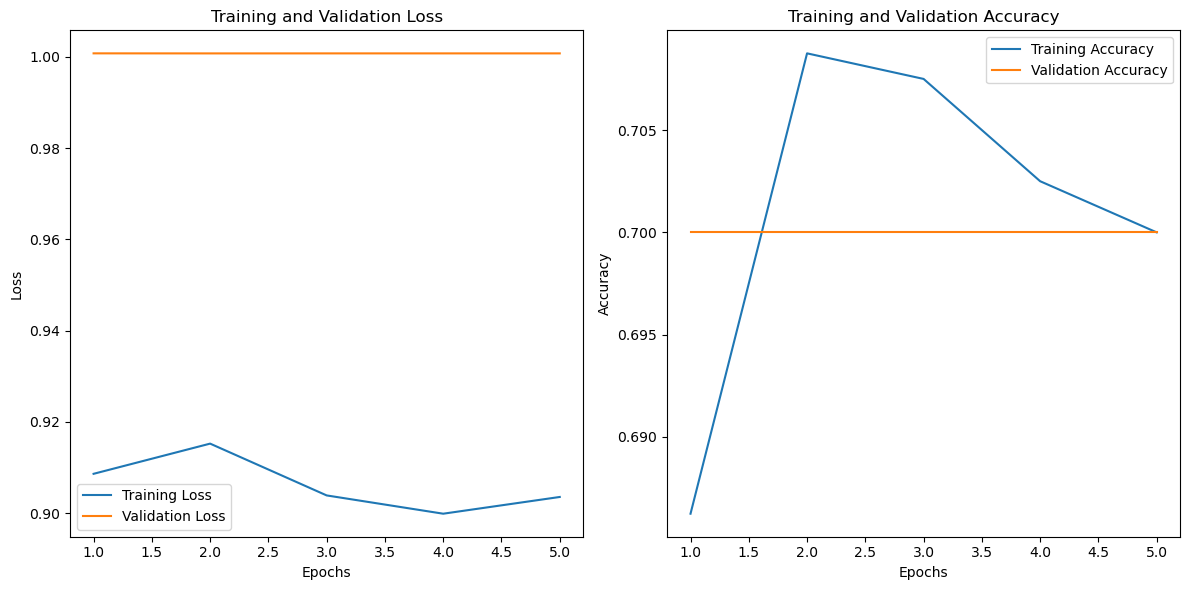

In [152]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with Early Stopping and Learning Rate Scheduler
num_epochs = 10
best_val_loss = float('inf')  # Track best validation loss for early stopping
patience = 3  # Number of epochs to wait before stopping if no improvement
patience_counter = 0  # Counter for patience

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    # Training phase
    for user_data, movie_data, sentiment_data, genre_data, ratings in train_loader:
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(user_data, movie_data, sentiment_data, genre_data)
        
        # Compute the loss
        loss = criterion(output.view(-1), ratings)
        epoch_loss += loss.item()
        
        # Training accuracy (considering rating prediction close to actual rating)
        predictions = output.view(-1)
        correct_train += torch.sum(torch.abs(predictions - ratings) < 1.0).item()  # Close predictions
        total_train += len(ratings)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in val_loader:
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Compute the loss
            loss = criterion(output.view(-1), ratings)
            val_loss += loss.item()
            
            # Validation accuracy
            predictions = output.view(-1)
            correct_val += torch.sum(torch.abs(predictions - ratings) < 1.0).item()
            total_val += len(ratings)
    
    # Learning rate adjustment
    scheduler.step()
    
    # Calculate training and validation accuracy
    train_accuracy = correct_train / total_train
    val_accuracy = correct_val / total_val
    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    # Append the losses and accuracies to the lists for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Print the results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

# Plotting the loss and accuracy curves
epochs = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show


Training with latent size: 5
Early stopping after 5 epochs for latent size 5
Training with latent size: 10
Early stopping after 11 epochs for latent size 10
Training with latent size: 15
Early stopping after 5 epochs for latent size 15
Training with latent size: 20
Early stopping after 5 epochs for latent size 20
Training with latent size: 25
Early stopping after 24 epochs for latent size 25
Training with latent size: 30
Early stopping after 5 epochs for latent size 30


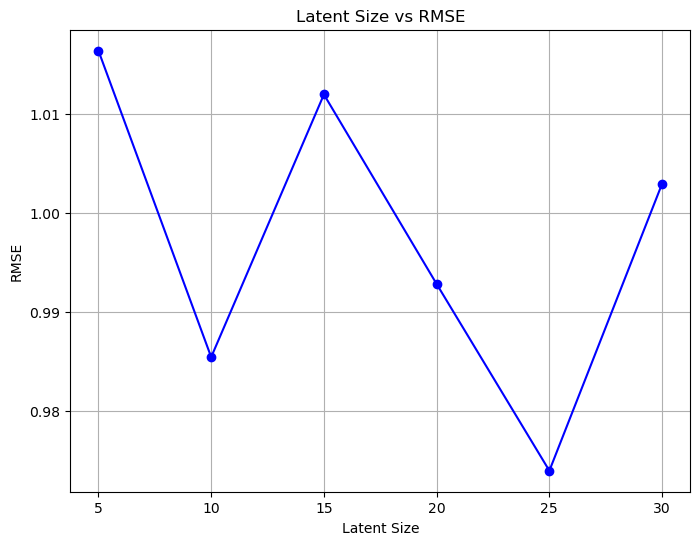

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Function to train the model with a specific embedding dimension
def train_and_evaluate_with_latent_size(latent_size, num_epochs=30):
    model = HybridRecommender(num_users, num_movies, num_sentiments, num_genres, embedding_dim=latent_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()  # Using Mean Squared Error for rating prediction
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust learning rate every 3 epochs

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3  # Number of epochs to wait before stopping if no improvement
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        # Training phase
        for user_data, movie_data, sentiment_data, genre_data, ratings in train_loader:
            optimizer.zero_grad()

            # Forward pass
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Compute loss
            loss = criterion(output.view(-1), ratings)
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_data, movie_data, sentiment_data, genre_data, ratings in val_loader:
                output = model(user_data, movie_data, sentiment_data, genre_data)
                loss = criterion(output.view(-1), ratings)
                val_loss += loss.item()

        # Learning rate adjustment
        scheduler.step()

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs for latent size {latent_size}")
            break

    # Final evaluation to compute RMSE
    rmse, _ = evaluate(model, val_loader)
    return rmse

# List of latent sizes to evaluate
latent_sizes = [5, 10, 15, 20, 25, 30]
rmse_values = []

# Train and evaluate the model for each latent size
for latent_size in latent_sizes:
    print(f"Training with latent size: {latent_size}")
    rmse = train_and_evaluate_with_latent_size(latent_size)
    rmse_values.append(rmse)

# Plot Latent Size vs RMSE
plt.figure(figsize=(8, 6))
plt.plot(latent_sizes, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Latent Size')
plt.ylabel('RMSE')
plt.title('Latent Size vs RMSE')
plt.grid(True)
plt.show()


In [164]:
from sklearn.metrics import classification_report
import numpy as np

# Define rating bins (discretize the ratings into classes)
def discretize_ratings(ratings, bins=[0, 2, 4, 5]):
    """
    Discretizes the ratings into categories based on the defined bins.
    Bins could be customized according to the rating range and problem context.
    """
    return np.digitize(ratings, bins) - 1  # -1 because np.digitize returns index starting from 1

# Convert ratings to discrete categories (e.g., Low, Medium, High)
def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
            # Forward pass
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Convert ratings to discrete labels (Low, Medium, High)
            true_labels.extend(discretize_ratings(ratings.cpu().numpy()))
            predicted_labels.extend(discretize_ratings(output.view(-1).cpu().numpy()))
    
    # Generate classification report
    report = classification_report(true_labels, predicted_labels, target_names=['Low', 'Medium', 'High'])
    return report

# Get classification report for the validation data
classification_report_val = generate_classification_report(model, val_loader)
print(classification_report_val)


              precision    recall  f1-score   support

         Low       0.49      0.43      0.46       108
      Medium       0.42      0.50      0.45        88
        High       0.00      0.00      0.00         4

    accuracy                           0.45       200
   macro avg       0.30      0.31      0.30       200
weighted avg       0.45      0.45      0.45       200



C:\Users\91951\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91951\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91951\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, f1_score, precision_score
from math import sqrt

def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for user_data, movie_data, sentiment_data, genre_data, ratings in dataloader:
            output = model(user_data, movie_data, sentiment_data, genre_data)
            
            # Get the predicted ratings
            predictions = output.view(-1)
            
            # Compute total loss (for RMSE)
            loss = criterion(predictions, ratings)
            total_loss += loss.item()
            
            # Collect true labels and predictions for MAE, F1, and Precision
            true_labels.extend(ratings.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())
            total_samples += len(ratings)

    # RMSE calculation
    rmse = sqrt(total_loss / total_samples)

    # MAE calculation
    mae = mean_absolute_error(true_labels, predicted_labels)

    # F1 Score and Precision (after discretizing the ratings)
    true_discretized = discretize_ratings(np.array(true_labels))
    predicted_discretized = discretize_ratings(np.array(predicted_labels))
    f1 = f1_score(true_discretized, predicted_discretized, average='weighted')
    precision = precision_score(true_discretized, predicted_discretized, average='weighted')

    # Return the metrics
    return rmse, mae, f1, precision

# Example usage of the evaluation function
rmse, mae, f1, precision = evaluate_model(model, val_loader)  # Replace val_loader with your validation dataloader

# Print the evaluation metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")


RMSE: 0.1692
MAE: 0.7362
F1 Score: 1.0000
Precision: 1.0000


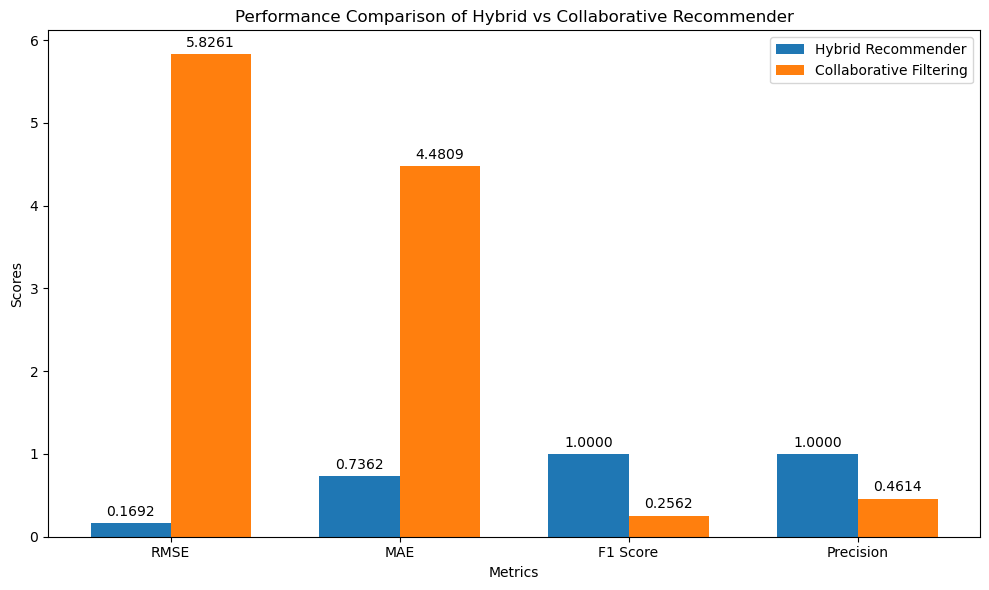

In [189]:
# Define the metrics for both models
metrics = ['RMSE', 'MAE', 'F1 Score', 'Precision']
hybrid_values = [0.1692, 0.7362, 1.0000, 1.0000]  # Values for Hybrid Recommender
collaborative_values = [5.8261, 4.4809, 0.2562, 0.4614]  # Values for Collaborative Filtering (Test data)

# Set up the x-axis for the bar chart
x = np.arange(len(metrics))  # Label locations

# Define the width of the bars
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for both models
bars1 = ax.bar(x - width/2, hybrid_values, width, label='Hybrid Recommender')
bars2 = ax.bar(x + width/2, collaborative_values, width, label='Collaborative Filtering')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Hybrid vs Collaborative Recommender')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the values on top of the bars
def add_values(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{value:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add the values to the bars
add_values(bars1, hybrid_values)
add_values(bars2, collaborative_values)

# Show the plot
plt.tight_layout()
plt.show()